In [21]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import logging
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from graphviz import Source
logging.getLogger("tensorflow").setLevel(logging.ERROR)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten

In [2]:
input_dir = "data"

In [3]:
# This data was downloaded from https://www.kaggle.com/ronitf/heart-disease-uci
heart_data = pd.read_csv(os.path.join(input_dir, "heart.csv"))
# Rename the variables to something more meaningful
heart_data.rename(index=str, columns={"cp": "chest_pain_type", "trestbps": "resting_bp",
                                     "chol": "serum_cholestrol", "fbs" : "fasting_blood_sugar",
                                     "restecg" : "resting_ecg", 
                                     "thalach" : "max_heart_rate",
                                     "exang" : "exercise_ind_angina",
                                     "oldpeak" : "st_depression",
                                     "ca" : "major_vessels_no"}, inplace=True)
# Now recode our variables to the correct data type and then generate dummy variables
heart_data.sex.replace({0: "female", 1: "male"}, inplace=True)
heart_data.chest_pain_type.replace(
    {1: "typical_angina", 2: "atypical_angina", 3: "non-typical_angina", 4: "asymtomatic"}, inplace=True
)
heart_data.fasting_blood_sugar.replace({0: "lower_than_120mg_per_ml", 1: "greater_than_120mg_per_ml"}, inplace=True)
heart_data.resting_ecg.replace({0: "normal", 1: "ST-T_wave_abnormality", 2: "left_ventrical_hypertrophy"}, inplace=True)
heart_data.exercise_ind_angina.replace({0: "no", 1: "yes"}, inplace=True)
heart_data.slope.replace({1: "upsloping", 2: "flat", 3: "downsloping"}, inplace=True)
heart_data.thal.replace({1: "normal", 2: "fixed_defect", 3: "reversible_defect"}, inplace=True)
heart_data = pd.get_dummies(heart_data, drop_first=True, sparse=True)
heart_data.head()

,age,resting_bp,serum_cholestrol,max_heart_rate,st_depression,major_vessels_no,target,sex_male,chest_pain_type_atypical_angina,chest_pain_type_non-typical_angina,chest_pain_type_typical_angina,fasting_blood_sugar_lower_than_120mg_per_ml,resting_ecg_left_ventrical_hypertrophy,resting_ecg_normal,exercise_ind_angina_yes,slope_flat,slope_upsloping,thal_fixed_defect,thal_normal,thal_reversible_defect
0,63,145,233,150,2.3,0,1,1,0,1,0,0,0,1,0,0,0,0,1,0
1,37,130,250,187,3.5,0,1,1,1,0,0,1,0,0,0,0,0,1,0,0
2,41,130,204,172,1.4,0,1,0,0,0,1,1,0,1,0,1,0,1,0,0
3,56,120,236,178,0.8,0,1,1,0,0,1,1,0,0,0,1,0,1,0,0
4,57,120,354,163,0.6,0,1,0,0,0,0,1,0,0,1,1,0,1,0,0


In [4]:
heart_data.dtypes

age                                                       int64
resting_bp                                                int64
serum_cholestrol                                          int64
max_heart_rate                                            int64
st_depression                                           float64
major_vessels_no                                          int64
target                                                    int64
sex_male                                       Sparse[uint8, 0]
chest_pain_type_atypical_angina                Sparse[uint8, 0]
chest_pain_type_non-typical_angina             Sparse[uint8, 0]
chest_pain_type_typical_angina                 Sparse[uint8, 0]
fasting_blood_sugar_lower_than_120mg_per_ml    Sparse[uint8, 0]
resting_ecg_left_ventrical_hypertrophy         Sparse[uint8, 0]
resting_ecg_normal                             Sparse[uint8, 0]
exercise_ind_angina_yes                        Sparse[uint8, 0]
slope_flat                              

### Plot the correlation between each pair of variables

High correlation between variables is something to bare in mind for the rest of the analysis

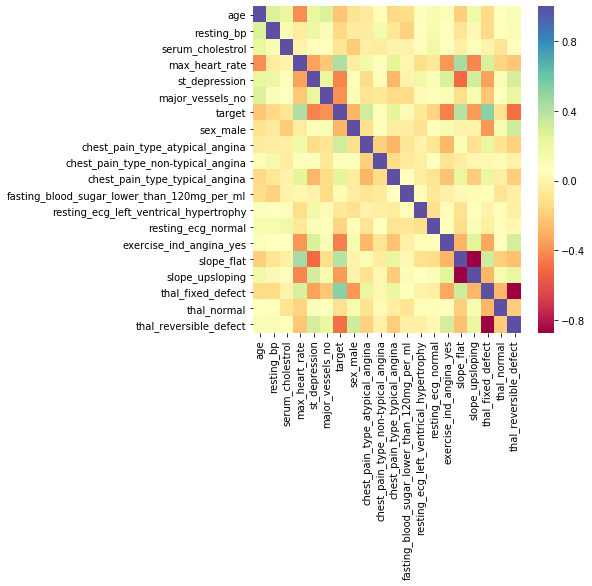

In [5]:
sns.heatmap(heart_data.corr(),
                cmap='Spectral') 
fig=plt.gcf()
fig.set_size_inches(6,6)
plt.show()

We also want to know what the correlation is between each variable and the target.

Note that the exercise induced angina has the greatest correlation with the target.

In [6]:
corr = heart_data.corr()['target'].abs().sort_values()
corr

fasting_blood_sugar_lower_than_120mg_per_ml    0.028046
resting_ecg_left_ventrical_hypertrophy         0.068410
serum_cholestrol                               0.085239
chest_pain_type_non-typical_angina             0.086957
thal_normal                                    0.106589
resting_bp                                     0.144931
resting_ecg_normal                             0.159775
age                                            0.225439
chest_pain_type_typical_angina                 0.245879
sex_male                                       0.280937
chest_pain_type_atypical_angina                0.316742
slope_upsloping                                0.362053
major_vessels_no                               0.391724
slope_flat                                     0.394066
max_heart_rate                                 0.421741
st_depression                                  0.430696
exercise_ind_angina_yes                        0.436757
thal_reversible_defect                         0

# Define the feature columns

In [7]:
feature_columns = []
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64', "uint8"]
numeric_df = heart_data.select_dtypes(include=numerics).drop(["target"], axis=1)
for feature_name in numeric_df.columns:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))
len(feature_columns)

19

# Split the data into training, test and validation datasets

In [8]:
# Split the data into a test and training dataset
train, test = train_test_split(heart_data, test_size=0.2, random_state=11)
test, validation = train_test_split(test, test_size=0.2, random_state=11)
y_train = train["target"]
y_test = test["target"]
y_validation = validation["target"]

In [9]:
# Convenience function
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    """Create a tensorflow dataset from a pandas dataset."""
    dataframe = dataframe.copy()
    labels = dataframe.pop('target')
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
        ds = ds.batch(batch_size)
    return ds

In [10]:
batch_size = 1000
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(validation, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [11]:
validation.shape

(13, 20)

# Generate the input functions function

In [12]:
# Adapted from https://medium.com/tensorflow/how-to-train-boosted-trees-models-in-tensorflow-ca8466a53127
def make_input_fn(X, y, n_epochs=None, shuffle=True):
    # Use entire batch since this is such a small dataset.
    number_examples = len(y_train)
    def input_fn():
        """The input function to apply."""
        dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
        if shuffle:
            dataset = dataset.shuffle(number_examples)
        # For training, cycle thru dataset as many times as need (n_epochs=None).    
        dataset = dataset.repeat(n_epochs)
        # In memory training doesn't use batching.
        dataset = dataset.batch(number_examples)
        return dataset
    return input_fn

# Training and evaluation input functions.
train_input_fn = make_input_fn(train, y_train)
eval_input_fn = make_input_fn(test, y_test, shuffle=False, n_epochs=100)

# Provide a baseline using Linear Regression

In [14]:
log_dir1 = os.path.join("logs", "linear_regression")
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns, model_dir=log_dir1)
linear_est.train(input_fn=train_input_fn, max_steps=100)
result_linear = linear_est.evaluate(input_fn=eval_input_fn)
result_linear

{'accuracy': 0.75,
 'accuracy_baseline': 0.6666667,
 'auc': 0.85253906,
 'auc_precision_recall': 0.9141391,
 'average_loss': 0.89697737,
 'label/mean': 0.6666667,
 'loss': 0.8967992,
 'precision': 0.7631579,
 'prediction/mean': 0.781269,
 'recall': 0.90625,
 'global_step': 100}

# Second model - Random Forest

Fits a decision tree-based model to the data

In [15]:
# Since data fits into memory, use entire dataset per layer. It will be faster.
# Above one batch is defined as the entire dataset.
n_batches = 1
log_dir2 = os.path.join("logs", "boosted_forest")
bt = tf.estimator.BoostedTreesClassifier(
    feature_columns=feature_columns, n_batches_per_layer=n_batches, model_dir=log_dir2
)

# The model will stop training once the specified number of trees is built, not
# based on the number of steps.
bt.train(train_input_fn, max_steps=1000)

# Eval.
result_random_forest = bt.evaluate(eval_input_fn)
result_random_forest

{'accuracy': 0.7083333,
 'accuracy_baseline': 0.6666667,
 'auc': 0.734375,
 'auc_precision_recall': 0.8653756,
 'average_loss': 3.332886,
 'label/mean': 0.6666667,
 'loss': 3.3326237,
 'precision': 0.8214286,
 'prediction/mean': 0.6000424,
 'recall': 0.71875,
 'global_step': 600}

# Plot the importance of difference factors in the decision tree

As expected, age comes out as the most importance factor, closely followed by the number of major vessels and the serum cholestrol

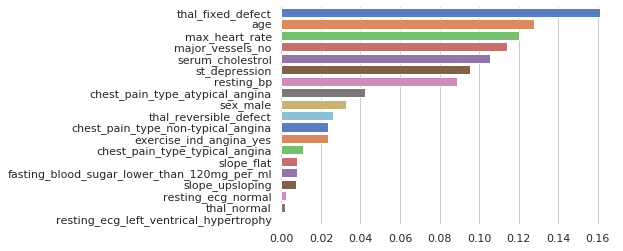

In [16]:
importances = pd.Series(bt.experimental_feature_importances(normalize=True))
sns.set(style="whitegrid")
ax = sns.barplot(importances.values, importances.index, palette=sns.color_palette("muted"))
sns.despine(left=True, bottom=True)

# Explore the scikit-learn tree so we can visualise the outcome better

In [17]:
rf_classifier = RandomForestClassifier(max_depth=5, n_estimators=100)
rf_classifier.fit(train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [18]:
estimators = rf_classifier.estimators_[1]
feature_names = [i for i in train.columns]

y_train_str = y_train.astype("str")
y_train_str[y_train_str == "0"] = "no disease"
y_train_str[y_train_str == "1"] = "disease"
y_train_str = y_train_str.values
tree = export_graphviz(
    estimators,
    feature_names=feature_names,
    class_names=y_train_str,
    rounded=True,
    proportion=True,
    label="root",
    precision=2,
    filled=True,
)

In [19]:
vis_tree = Source(tree)

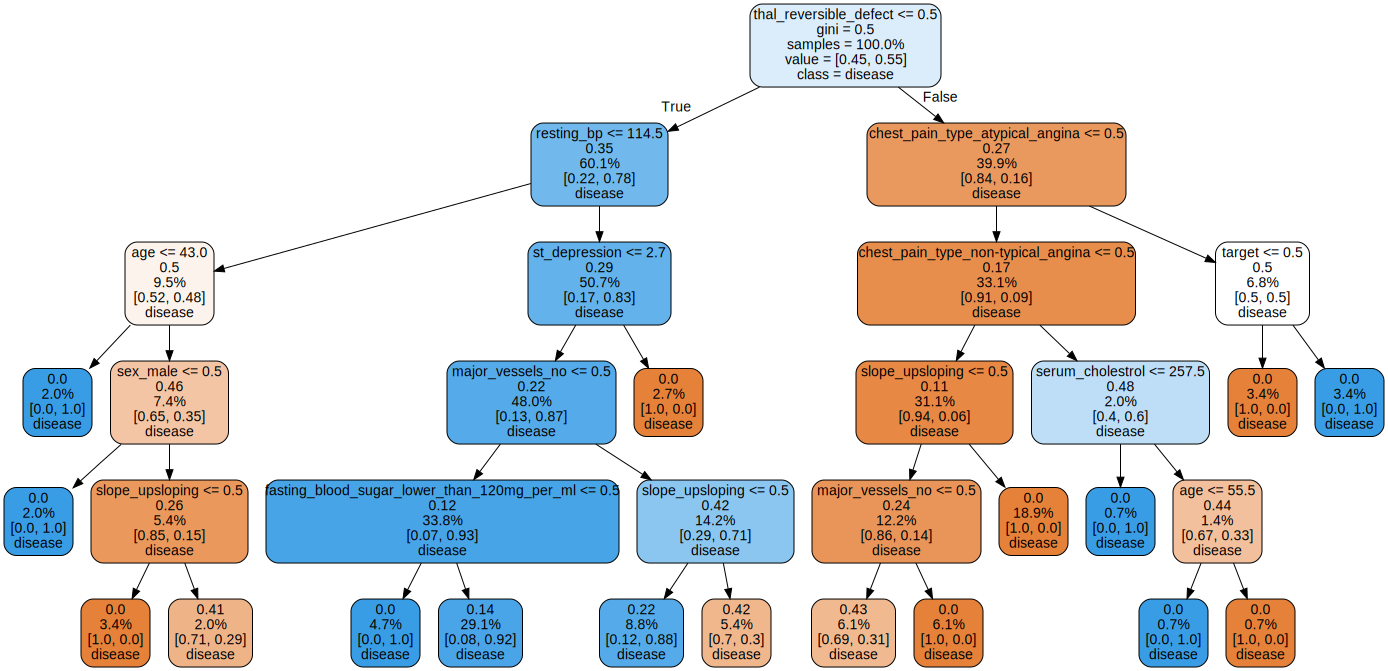

In [20]:
vis_tree.render(os.path.join("outputs", "sklearn_decision_tree"))
vis_tree